In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
import os, sys, time
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
def double_conv(nbr_channels_in, nbr_channels_out):
    return nn.Sequential(
      nn.Conv2d(nbr_channels_in, nbr_channels_out, (3,3), padding=(1, 1)),
      nn.BatchNorm2d(nbr_channels_out),
      nn.ReLU(),
      nn.Conv2d(nbr_channels_out, nbr_channels_out, (3,3), padding=(1, 1)),
      nn.ReLU(),
      nn.BatchNorm2d(nbr_channels_out),
)


def one_step_up(x, x_d_i, pre_up_i, up_i):
    return up_i(torch.cat((pre_up_i(x), x_d_i), dim=1))


class u_net(nn.Module):
    def __init__(self):
        super(u_net, self).__init__()

        self.down_pooling = nn.MaxPool2d(2, 2)

        # Convolution Downwards
        self.down_1 = double_conv(3, 64) 
        self.down_2 = double_conv(64, 128)
        self.down_3 = double_conv(128, 256)
        self.down_4 = double_conv(256, 512)
        self.middle =  double_conv(512, 1024)
        
        # Upconvolution
        self.pre_up_1 = nn.ConvTranspose2d(1024, 512, (2, 2), (2, 2))
        self.up_1 = double_conv(512 + 512, 512)
                
        self.pre_up_2 = nn.ConvTranspose2d(512, 256, (2, 2), (2, 2))
        self.up_2 = double_conv(256 + 256, 256)
          
        self.pre_up_3 = nn.ConvTranspose2d(256, 128, (2, 2), (2, 2))
        self.up_3 = double_conv(128 + 128, 128)

        self.pre_up_4 = nn.ConvTranspose2d(128, 64, (2, 2), (2, 2))
        self.up_4 = double_conv(64 + 64, 64)

        self.final_convolution = nn.Conv2d(64, 2, (1,1))
        

    def forward(self, x):
        x_d_1 = self.down_1(x)
        x_d_2 = self.down_2(self.down_pooling(x_d_1))
        x_d_3 = self.down_3(self.down_pooling(x_d_2))
        x_d_4 = self.down_4(self.down_pooling(x_d_3))

        x = self.middle(self.down_pooling(x_d_4))

        x = one_step_up(x, x_d_4, self.pre_up_1, self.up_1)
        x = one_step_up(x, x_d_3, self.pre_up_2, self.up_2)
        x = one_step_up(x, x_d_2, self.pre_up_3, self.up_3)
        x = one_step_up(x, x_d_1, self.pre_up_4, self.up_4)
        
        return self.final_convolution(x)


In [5]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model:           model that we want to load checkpoint parameters into       
    optimizer:       optimizer we defined in previous training
    
    Return model, optimizer, scheduler, epoch value, f1 score
    """
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # Get epoch number, f1_max, scheduler
    epoch = checkpoint['epoch']
    f1_max = checkpoint['f1_max']
    scheduler = checkpoint['scheduler']
    f1_validation = checkpoint['f1_validation']
    acc_validation = checkpoint['acc_validation']
    f1_training = checkpoint['scheduler']
    acc_training = checkpoint['acc_training']

    return model, optimizer, scheduler, epoch, f1_max, f1_validation, acc_validation, f1_training, acc_training

In [7]:
CHECKPOINT_K_FOLD_PATH_ROOT ="/content/drive/MyDrive/ml_epfl/ml_road_segmentation/checkpoint/k_folds_checkpoints/"
BEST_MODEL_K_FOLD_PATH_ROOT ="/content/drive/MyDrive/ml_epfl/ml_road_segmentation/checkpoint/k_folds_checkpoints/"
K_FOLD = 4

OPTIMIZERS_NAMES = ["SGD_", "ADAM_", "ADAM_W_"]
models_f1 = {"SGD_" : [], "ADAM_" : [], "ADAM_W_" : []}
for opti_name in OPTIMIZERS_NAMES:
    for idx_validaton_set in range(K_FOLD):     
        CHECKPOINT_K_FOLD_PATH = CHECKPOINT_K_FOLD_PATH_ROOT + opti_name + 'fold_' + str(idx_validaton_set) +'_all_data.pt'
        f1_max = torch.load(CHECKPOINT_K_FOLD_PATH)["f1_max"]
        models_f1[opti_name].append(f1_max)

In [14]:
for key, value in models_f1.items():
    print(key, np.mean(value), np.max(value))

SGD_ 0.20625780280222572 0.243922166664875
ADAM_ 0.19775639371255124 0.22793948073209647
ADAM_W_ 0.20331537549014458 0.2693007091976238


In [37]:
OPTIMIZERS_NAMES = ["SGD_"]#, "ADAM_", "ADAM_W_"]
models_f1_evolution = {"SGD_" : [], "ADAM_" : [], "ADAM_W_" : []}
for opti_name in OPTIMIZERS_NAMES:
    for idx_validaton_set in range(K_FOLD):     
        CHECKPOINT_K_FOLD_PATH = CHECKPOINT_K_FOLD_PATH_ROOT + opti_name + 'fold_' + str(idx_validaton_set) +'_all_data.pt'
        f1_evolution = torch.load(CHECKPOINT_K_FOLD_PATH)["f1_validation"]
        models_f1_evolution[opti_name].append(f1_evolution)

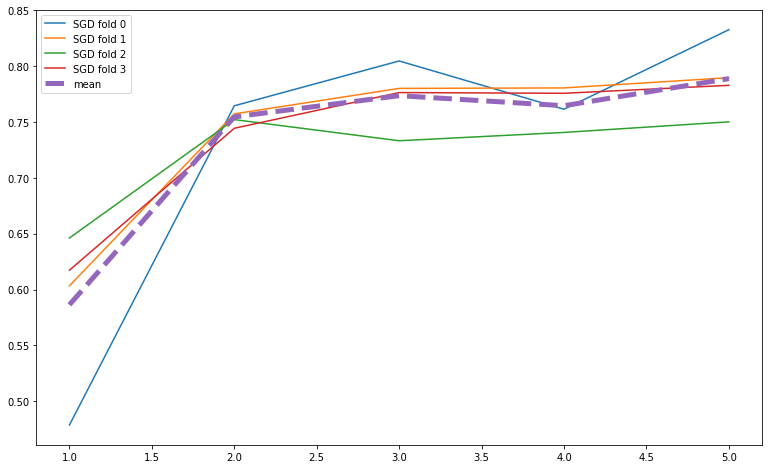

In [50]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 8))
OPTIMIZER_NAME = "SGD_"
NBR_EPOCHS = 5
x = list(range(1, NBR_EPOCHS+1))
for idx in range(K_FOLD):
    f1_evolution = models_f1_evolution[OPTIMIZER_NAME][idx]
    plt.plot(x, f1_evolution, label=f"{OPTIMIZER_NAME[:-1]} fold {idx}")
    
plt.plot(x, np.mean(models_f1_evolution[ "SGD_"], axis = 0), label="mean", ls ="--", lw=5)
plt.legend()
plt.show()